## This notebook comprises a data analysis of rental listings data, in which we try to estimate rental prices at the city level for SF Bay Area cities. 

### NB: This notebook is essentially a demo of the data_analysis.py script, and to run this script or notebook, we assume we have performed the 1st 2 phases of this webcrawler project: ie, we have already done the following: 1.) Used the webcrawler at least once; & 2.) We have cleaned and wrangled the scraped data, and we have used the Pandas' DataFrame to SQL data pipeline so that we have the data stored into a SQL Server table.

### The steps of this data analysis phase of the project are as follows: 

### A.) We start by importing the data from the SQL rental table, but ensure that price > $1. B.) We then ensure the variables are of the correct data type, and we will remove any columns that are irrelevant to an empirical analysis of rental prices. C.) We then perform some data exploration, such as examining the distribution of several key variables, such as rental price (the outcome variable), number of bedrooms, and square feet. D.) We wrangle, normalize, and prepare the data by using multiple (k-fold) cross validation to split the overall dataset into several segments, each of which will be used to train several different regression models. E.) Finally, we implement The notebook is essentially a demo of the data_analysis.py script:various regression models, including comparing the predictive accuracy of the models. Using the most accurate models, we will make predictions of city-level rental prices.  

In [25]:
# imports:
# file processing
import os
import glob

# data analysis libraries & SQL libraries
import numpy as np
import pandas as pd
# SQL ODBC for API connection between Python & SQL Server
import pyodbc
import sqlalchemy as sa

# data visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import json

# statistical and ML modeling and hypothesis testing libraries
from sklearn.model_selection import KFold   # k-fold cross validation
from sklearn.model_selection import train_test_split  # split datasets into training & test datasets
from sklearn import linear_model  # OLS 
from sklearn import ensemble  # ensemble module contains the GradientBoostingRegressor class, which is used to estimate Gradient-boosted regression models

from sklearn.metrics import mean_squared_error  # calculate MSE to estimate accuracy of regression models 


## A.) Import data from SQL table, but ensure square feet data is available (ie, is not null) and price > $1: 

In [2]:
# import data from rental table
class SQL_Database():
    def __init__(self, sql_config_path):

        with open(sql_config_path, 'r') as fh:
            config = json.load(fh)

        self.driver = config['driver']
        self.server = config['server']
        self.database = config['database']
        self.username = config['username']
        self.password = config['password']
        print(f"Name of connected database:\n{self.database}")


    def import_SQL_to_df(self, sql_query):
        """Import dataset by using SQL query and Pandas' read_sql() method"""
        conn = pyodbc.connect(
            f'DRIVER={self.driver};'
            f'SERVER={self.server};'
            f'DATABASE={self.database};'
            f'UID={self.username};'
            f'PWD={self.password};'
            'Trusted_Connection=yes;'
        )

        # establish connection to SQL Server database, by passing in the database name, etc., using a with statement so it will automatically close the connection & cursor once the with statement has completed execution:
        # initialize cursor so we can execute SQL code
        cursor = conn.cursor() 

        # query to select all records in which a.) sqft data exists (ie, NOT NULL) and b.) where price > $1, since such a price is essentially impossible and likely a typo from the original scraped rental listing
        # specify SQL query
        sql = sql_query 

        # export SQL query results to Pandas' DataFrame
        df = pd.read_sql(sql,conn)  # export results of SQL query to Pandas' DataFrame

        cursor.close()
        conn.close()
        return df


## import data with no sqft nulls and price >$1, via SQL query to Pandas' df
# specify path to json file containing SQL configuration/username data
sql_config_path = "D:\\Coding and Code projects\\Python\\craigslist_data_proj\\CraigslistWebScraper\\SQL_config\\config.json" 

SQL_db = SQL_Database(sql_config_path)  # NB: be sure to pass in path to the json SQL configuration file so we can load in the needed username, password, and configuration data to be able to access the SQL database

# specify query for data selection
query = """SELECT * FROM rental WHERE price > 1;"""
# import data to DataFrame via SQL query and Pandas' read_sql() method
df = SQL_db.import_SQL_to_df(query)
df.info() # sanity check

Name of connected database:
craigslist
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12117 entries, 0 to 12116
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   listing_id               12117 non-null  int64         
 1   sqft                     12117 non-null  int64         
 2   city                     12117 non-null  object        
 3   price                    12117 non-null  int64         
 4   bedrooms                 12117 non-null  int64         
 5   bathrooms                12117 non-null  float64       
 6   attr_vars                12117 non-null  object        
 7   date_of_webcrawler       12117 non-null  datetime64[ns]
 8   kitchen                  12117 non-null  int64         
 9   date_posted              12117 non-null  datetime64[ns]
 10  region                   12117 non-null  object        
 11  sub_region               12117 non-null  object       

## B.) Ensure each column is of the correct data type, and remove columns that are irrelevant to quantifying rental price:

In [3]:
## Data cleaning and feature engineering--ensure columns are of correct data type:
print(f"Data types of each column from queried SQL rental table:\n{df.dtypes}")

Data types of each column from queried SQL rental table:
listing_id                          int64
sqft                                int64
city                               object
price                               int64
bedrooms                            int64
bathrooms                         float64
attr_vars                          object
date_of_webcrawler         datetime64[ns]
kitchen                             int64
date_posted                datetime64[ns]
region                             object
sub_region                         object
cats_OK                             int64
dogs_OK                             int64
wheelchair_accessible               int64
laundry_in_bldg                     int64
no_laundry                          int64
washer_and_dryer                    int64
washer_and_dryer_hookup             int64
laundry_on_site                     int64
full_kitchen                        int64
dishwasher                          int64
refrigerator       

## B2) Next, let's add some additional columns, especially in relation to time series--

### Namely: add a weekday col to specify the names of weekdays for each given rental listing's date_posted

In [65]:
def create_weekday_name_col(df, datetime_col):
    return df[datetime_col].dt.day_name()

df['weekday'] = create_weekday_name_col(df, 'date_posted')
df[['weekday', 'date_posted']] # sanity check

,weekday,date_posted
0,Monday,2021-09-06 21:54:00
1,Tuesday,2021-09-07 12:05:00
2,Thursday,2021-09-09 10:25:00
3,Friday,2021-09-10 16:06:00
4,Friday,2021-09-10 22:00:00
...,...,...
12112,Friday,2022-02-04 16:47:00
12113,Friday,2022-02-04 17:01:00
12114,Friday,2022-02-04 17:06:00
12115,Friday,2022-02-04 17:08:00


## C.) Data exploration and visualizations


### Let's start by examining the distributions of several key variables such as rental price, # of bedrooms, # of bathrooms, and sqft:





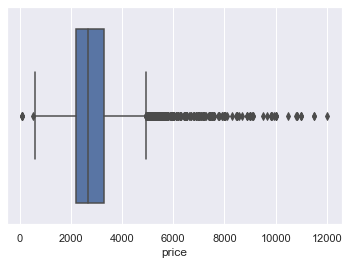

In [5]:
## boxplots of important variables
def boxplot(df, col, hue_option_col):
    """Implement boxplot of given col from given dataset (df)"""
    sns.set_theme(style="darkgrid")
    ax = sns.boxplot(x=df[col], hue=hue_option_col)
    

## distribution of price (overall dataset) boxplot
boxplot(df, 'price', None) # distribution of price overall


### At first glance, notice that the distribution of price is highly positively skewed, with the upper quartile of rental prices having values that exceed the median value of price (roughly $2,500) very substantially.

### Next, let's examine the data at a somewhat finer granmularity: examine a boxplot of price, but differentiate the price distributions by the number of bedrooms:

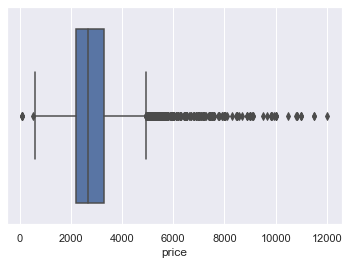

In [6]:

## distribution of price by number of bedrooms boxplot
boxplot(df, 'price', df['bedrooms']) # distribution of price by number of bedrooms

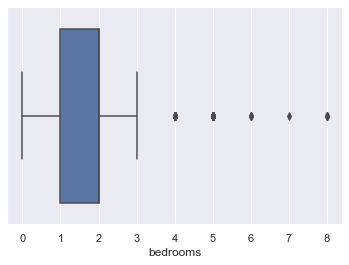

In [7]:
## distribution of number of bedrooms boxplot
boxplot(df, 'bedrooms', None) # distribution of  number of bedrooms

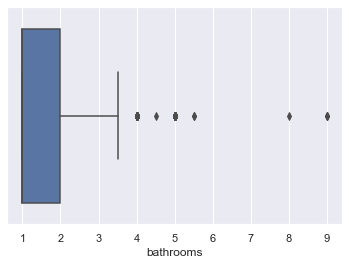

In [8]:
## distribution of number of bathrooms boxplot
boxplot(df, 'bathrooms', None) # distribution of  number of bathrooms

### Examine distribution of data by whether a rental is furnished:

In [25]:
# distribution of data by is furnished: 
df.is_furnished.value_counts()

0    10271
1      633
Name: is_furnished, dtype: int64

## Let's examine whether the distributions of price, # of bedrooms, etc. differs by Bay Area subregion:

### NB!: see following for how to use .melt() and then do a buxplot of separate groups: <https://stackoverflow.com/questions/53109236/boxplot-with-groupby-two-features>

<AxesSubplot:xlabel='price'>

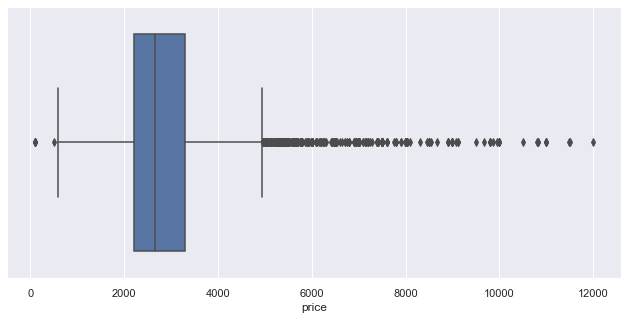

In [95]:
# boxplot of rental prices by sub_region:
def multiple_boxplot_subplot(df, col_to_plot, hue_option):
    # use plt.subplots() to allow for multiple boxplots in same figure
    fig, ax = plt.subplots(figsize=(11,5))
    return sns.boxplot(data=df, x=col_to_plot, hue=hue_option, ax=ax)

multiple_boxplot_subplot(df, 'price', 'sub_region')

### Data visualizations and data exploration-- Countplots of variables such as # of bedrooms, and include percent of total:


### Among the relatively few rental listings that are furnished, how many bedrooms do these rental listings tend to have relative to non-furnished rental listings?:

### Countplot of # of bedrooms by whether the rental is furnished:

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 44

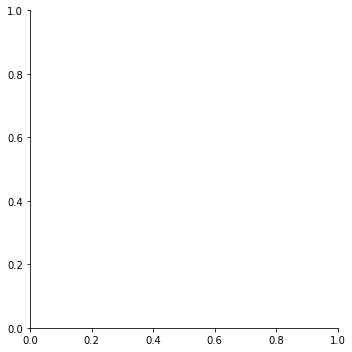

In [31]:
# countplot of number of bedrooms by whether a rental is furnished:




# group dataset by is_furnished, and look up the % of total distributions of the number of bedrooms:
df_bedrooms = df.groupby('bedrooms')['is_furnished'].value_counts(normalize=True)
df_bedrooms = df_bedrooms.mul(100)
df_bedrooms = df_bedrooms.rename('percent').reset_index()

g = sns.catplot(x=df['bedrooms'],y='percent',hue=df['is_furnished'],kind='bar',data=df_bedrooms)
g.ax.set_ylim(0,100)

for perc in g.ax.patches:
    txt = str(perc.get_height().round(1)) + '%'
    txt_x = perc.get_x() 
    txt_y = perc.get_height()
    g.ax.text(txt_x,txt_y,txt)

### How does the number of bedrooms relate to the number of bathrooms?

### Countplot of the distribution of the number of bedrooms by the number of bathrooms:

In [ ]:
# countplot of number of bedrooms- distribution by # of bathrooms


### Next, let's examine correlations of variables with rental price (ie, the outcome variable)

In [ ]:
# scatterplot of sqft and rental price

In [ ]:
# scatterplot of # of bedrooms and rental price

## Next, let's examine the data at the subregion level (ie, sfc vs sby, etc.) and then at the city level

### Rental prices & sqft by subregion: 

In [21]:
### group data by subregion level-- price & sqft summary stats
def groupby_multiple_aggs_and_cols(df, groupby_col, agg_col_1, agg_col_2):
    df_groupby = df.groupby([groupby_col]).agg(
        {agg_col_1: ['count', 'max', 'mean', 'median', 'std', 'min']},
        {agg_col_2: ['count', 'max', 'mean', 'median', 'std', 'min']})
    return df_groupby


# 

print(f"Comparing rental prices & sqft by subregion:\n{groupby_multiple_aggs_and_cols(df, 'sub_region', 'price', 'sqft')}")


Comparing rental prices & sqft by subregion:

           price                                              
           count    max         mean  median          std  min
sub_region                                                    
eby         3677  11000  2555.202339  2460.0   805.515268  600
nby         1230  11500  2667.516260  2500.0  1128.078741  100
pen         2358  12000  3282.591179  3158.5  1219.151065  700
sby         3241   9950  2884.941685  2728.0   934.667199  590
scz          160   6500  2640.356250  2300.0  1119.136490  950
sfc         1451  11495  3162.416265  2884.0  1435.375434  100


In [ ]:
## visualize and compare avg prices by subregion

## Let's also examine whether median rental prices have fluctuated signficantly over time, and see whether this has also happened across specific (or all) subregions over time:

### Lineplot of raw rental prices (ie, using overall dataset): 

<AxesSubplot:xlabel='date_posted', ylabel='price'>

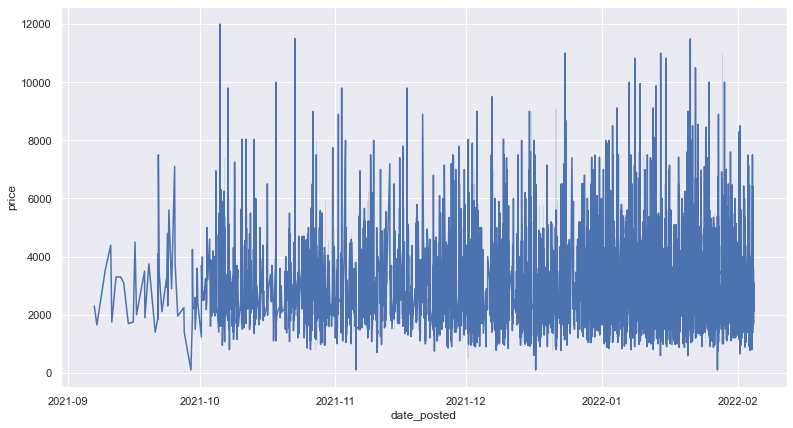

In [26]:
## Rental prices by subregion over time


# Lineplot of prices over time (ie, using overall dataset) 
plt.figure(figsize=(13, 7))

sns.lineplot(x='date_posted', y='price', data=df)

In [35]:
## Get groupby of median for subregion
def groupby_single_agg_median(df, col_to_group, col_agg_calc):
    return df.groupby(col_to_group)[col_agg_calc].median()


# specify cols to agg
subregion_and_date = ['sub_region', 'date_posted']

# median prices by subregion & date_posted 
sub_region_median_prices = groupby_single_agg_median(df, subregion_and_date, 'price')

# sanity check
sub_region_median_prices


sub_region  date_posted        
eby         2021-09-29 08:15:00    1900.0
            2021-09-29 08:23:00    4250.0
            2021-09-30 10:32:00    3600.0
            2021-10-01 12:18:00    2567.0
            2021-10-02 08:05:00    3250.0
                                    ...  
sfc         2022-02-03 19:55:00    1800.0
            2022-02-03 21:07:00    3480.0
            2022-02-03 21:48:00    2800.0
            2022-02-04 00:02:00    2980.0
            2022-02-04 00:35:00    3095.0
Name: price, Length: 11646, dtype: float64

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [62]:
df.date_posted.value_counts()

2021-11-28 01:24:00    5
2021-11-29 12:04:00    4
2021-12-07 10:48:00    4
2021-12-16 12:08:00    3
2021-12-02 16:27:00    3
                      ..
2021-12-16 10:58:00    1
2021-12-16 11:19:00    1
2021-11-19 12:45:00    1
2021-12-16 11:36:00    1
2022-01-01 19:02:00    1
Name: date_posted, Length: 11378, dtype: int64

<AxesSubplot:xlabel='date_posted', ylabel='price'>

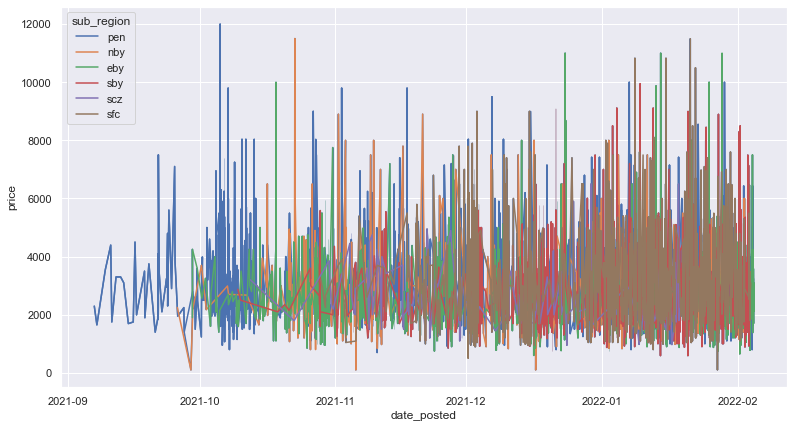

In [37]:
# Lineplot of prices over time by subregion
plt.figure(figsize=(13, 7))

sns.lineplot(x='date_posted', y='price', data=df)

sns.lineplot(x='date_posted', y='price', data=df, hue='sub_region')  

## There are clear fluctuations in rental prices, but we should examine if there are seasonality patterns that show distinct differences in rental prices by weekday, and also examine if 7-day rolling avgs show more of a clear pattern than the noise very comonn in raw time series:

## Calculate median prices, bedrooms, & sqft by weekday name:

In [54]:
df_subreg_prices_weekday = df.groupby(
    [df['date_posted'].dt.day_name(), "sub_region"])["price", "bedrooms", "sqft"].median()

df_subreg_prices_weekday


d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


price  bedrooms     sqft
date_posted sub_region                           
Friday      eby         2500.0       2.0   7500.0
            nby         2575.0       2.0   8500.0
            pen         3000.0       2.0   8760.0
            sby         2650.0       2.0   8500.0
            scz         2695.0       1.0   7200.0
            sfc         2775.0       1.0   5090.0
Monday      eby         2425.0       2.0   6590.0
            nby         2387.0       2.0   8000.0
            pen         3299.0       2.0   9000.0
            sby         2665.0       1.0   8180.0
            scz         2150.0       1.0   7500.0
            sfc         2977.0       1.0   1420.0
Saturday    eby         2400.0       2.0   7000.0
            nby         2182.0       1.0   6880.0
            pen         3160.0       2.0   9150.0
            sby         2796.0       2.0   9215.0
            scz         2550.0       1.0   7790.0
            sfc         2961.5       1.0   2085.0
Sunday      eby         2515.0       2.0   7500.0
            nby         2595.5       2.0   8500.0
            pen         3293.5       2.0   9150.0
            sby         2947.0       2.0   8820.0
            scz         2350.0       2.0   9500.0
            sfc         3200.0       1.0   4160.0
Thursday    eby         2484.0       2.0   7040.0
            nby         2441.0       2.0   8100.0
            pen         3125.0       2.0   8500.0
            sby         2764.0       2.0   8630.0
            scz         1995.0       1.0   4375.0
            sfc         2800.0       1.0   5260.0
Tuesday     eby         2474.5       2.0   6315.0
            nby         2500.0       2.0   8500.0
            pen         2975.0       2.0   8500.0
            sby         2754.5       1.0   8160.0
            scz         2200.0       2.0   8560.0
            sfc         2800.0       1.0   3770.0
Wednesday   eby         2445.0       2.0   7720.0
            nby         2473.0       2.0   7260.0
            pen         3140.0       2.0   9000.0
            sby         2706.0       1.0   8190.0
            scz         2550.0       2.0  10500.0
            sfc         2700.0       1.0   4450.0

## Notice we need to re-sort the index so the df_subreg_prices_weekday dataframe is sorted by weekday in terms of Monday, Tuesday, etc., instead of the automatic alpha ordering!!

### Sort the data by weekday in the *normal* Monday, Tuesday,..., Sunday order:

### NB: We can do this by:

### a) Specifying a list defining the *correct* order of weekday names

### b.) Using pd.Categorical() to convert the weekday names to categorical,
& 
### c) Use .sort_values() to sort the values of the DataFrame


## NB: For reference, see following: <https://stackoverflow.com/questions/53575689/pandas-groupby-how-to-sort-weekdays-in-the-correct-order-when-creating-groupby>

In [60]:
# specify a list to define the *correct* order of the weekday names
weekdays =  ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# convert weekday names to categorical, using the list values as the categories arg
df_subreg_prices_weekday.date_posted = pd.Categorical(df_subreg_prices_weekday.date_posted ,categories=weekdays)

# sort the weekday data by *correct* weekday order
df_subreg_prices_weekday = df_subreg_prices_weekday.sort_values('date_posted')


AttributeError: 'DataFrame' object has no attribute 'date_posted'

In [58]:
df_subreg_prices_weekday.sort_index(axis=0)


price  bedrooms     sqft
date_posted sub_region                           
Friday      eby         2500.0       2.0   7500.0
            nby         2575.0       2.0   8500.0
            pen         3000.0       2.0   8760.0
            sby         2650.0       2.0   8500.0
            scz         2695.0       1.0   7200.0
            sfc         2775.0       1.0   5090.0
Monday      eby         2425.0       2.0   6590.0
            nby         2387.0       2.0   8000.0
            pen         3299.0       2.0   9000.0
            sby         2665.0       1.0   8180.0
            scz         2150.0       1.0   7500.0
            sfc         2977.0       1.0   1420.0
Saturday    eby         2400.0       2.0   7000.0
            nby         2182.0       1.0   6880.0
            pen         3160.0       2.0   9150.0
            sby         2796.0       2.0   9215.0
            scz         2550.0       1.0   7790.0
            sfc         2961.5       1.0   2085.0
Sunday      eby         2515.0       2.0   7500.0
            nby         2595.5       2.0   8500.0
            pen         3293.5       2.0   9150.0
            sby         2947.0       2.0   8820.0
            scz         2350.0       2.0   9500.0
            sfc         3200.0       1.0   4160.0
Thursday    eby         2484.0       2.0   7040.0
            nby         2441.0       2.0   8100.0
            pen         3125.0       2.0   8500.0
            sby         2764.0       2.0   8630.0
            scz         1995.0       1.0   4375.0
            sfc         2800.0       1.0   5260.0
Tuesday     eby         2474.5       2.0   6315.0
            nby         2500.0       2.0   8500.0
            pen         2975.0       2.0   8500.0
            sby         2754.5       1.0   8160.0
            scz         2200.0       2.0   8560.0
            sfc         2800.0       1.0   3770.0
Wednesday   eby         2445.0       2.0   7720.0
            nby         2473.0       2.0   7260.0
            pen         3140.0       2.0   9000.0
            sby         2706.0       1.0   8190.0
            scz         2550.0       2.0  10500.0
            sfc         2700.0       1.0   4450.0

## Lineplot of rental prices by weekday:


# NB!: I need to *sort* the df_subreg_prices_weekday dataframe by weekday in terms of Monday, Tuesday, etc., instead of the automatic alpha ordering!!

## Here's a possible solution: <https://stackoverflow.com/questions/35193808/re-order-pandas-series-on-weekday>

## Also see 



<AxesSubplot:title={'center':'Median Rental Prices By Weekday & Subregion'}, xlabel='date_posted', ylabel='price'>

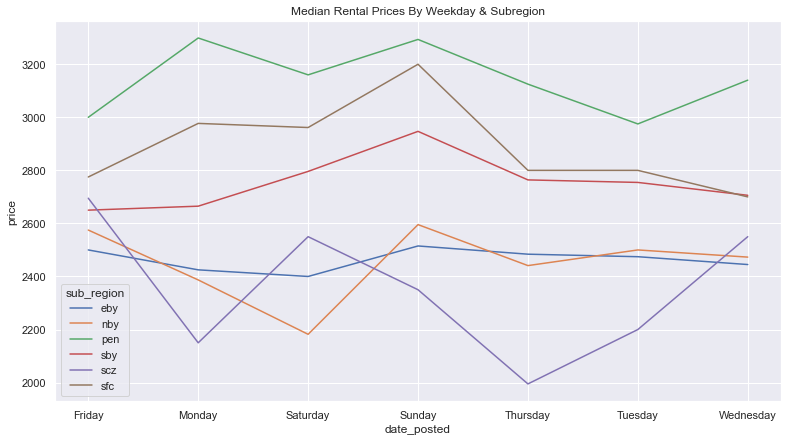

In [59]:
def lineplot_seaborn(figsize_tuple, df, datetime_col, col_y_axis, hue_col_option, plot_title):
    plt.figure(figsize=figsize_tuple)  # specify plot's figure size
    pl = sns.lineplot(x=datetime_col, y= col_y_axis, data=df, hue=hue_col_option)  
    pl.set(title= plot_title) # specify title
    return pl

lp_title_weekday_median_subreg = "Median Rental Prices By Weekday & Subregion"  # specify plot's title

lineplot_seaborn((13, 7), df_subreg_prices_weekday, 'date_posted', 'price',  'sub_region', lp_title_weekday_median_subreg)


## Next, let's compare rental prices on a daily basis by a 7-day rolling avg:

## NB!!: Check following for an example: <https://datavizpyr.com/how-to-make-a-time-series-plot-with-rolling-average-in-python/>

## Look up plot entitled "Time Series Plot with 7-day rolling average: Pandas and Seaborn"

## Group data by week over week & subregion

In [83]:
df_subreg_prices_weekly = df.groupby(
    [df['date_posted'].dt.week, df['date_posted'].dt.year, "sub_region"])["price", "bedrooms", "sqft"].median()

df_subreg_prices_weekly


d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


price  bedrooms    sqft
date_posted date_posted sub_region                          
1           2022        eby         2380.0       2.0  1263.0
                        nby         2182.0       1.0  7130.0
                        pen         3195.0       2.0  9300.0
                        sby         2795.0       2.0  8170.0
                        scz         2600.0       2.0  8440.0
...                                    ...       ...     ...
52          2022        eby         2500.0       2.0  8510.0
                        nby         2100.0       1.0  7250.0
                        pen         2997.5       1.0  8500.0
                        sby         2601.0       1.0  8000.0
                        sfc         3222.5       2.0  6320.0

[113 rows x 3 columns]

## Lineplot of week over week subregion prices:

<AxesSubplot:title={'center':'Week over Week Median Rental Prices By Subregion'}, xlabel='date_posted', ylabel='price'>

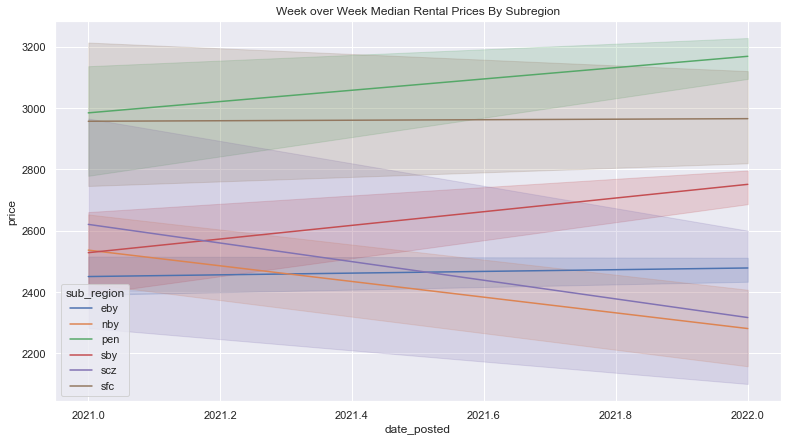

In [84]:
lp_title_weekday_median_subreg = "Week over Week Median Rental Prices By Subregion"  # specify plot's title

lineplot_seaborn((13, 7), df_subreg_prices_weekly, 'date_posted', 'price',  'sub_region', lp_title_weekday_median_subreg)


d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<AxesSubplot:title={'center':'Week over Week Median Rental Prices (overall)'}, xlabel='date_posted', ylabel='price'>

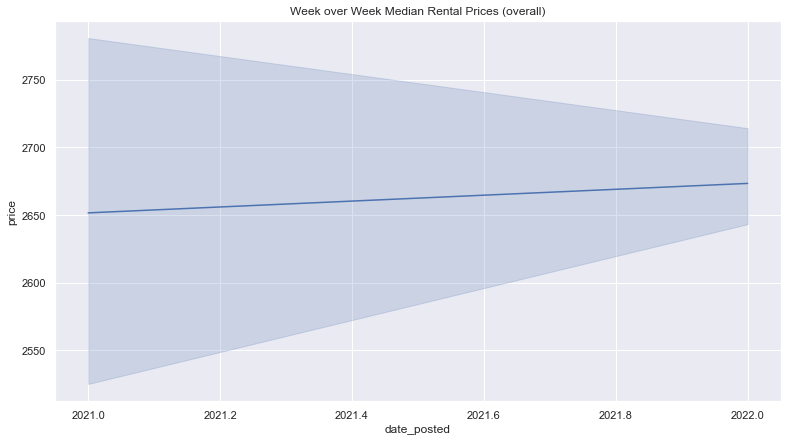

In [81]:
df_prices_weekly = df.groupby(
    [df['date_posted'].dt.week, df['date_posted'].dt.month, df['date_posted'].dt.year])["price", "bedrooms", "sqft"].median()

df_prices_weekly

lp_title_weekday_median_subreg = "Week over Week Median Rental Prices (overall)"  # specify plot's title

lineplot_seaborn((13, 7), df_prices_weekly, 'date_posted', 'price', None, lp_title_weekday_median_subreg)



## The Week over Week lineplot indicates a very gradual increase in overall weekly median rent prices.

## Let's next examine month over month data, since this would likely show more pronounced increases in median rental prices.

## Monthly rental prices:

### NB: I need to account for the year as well as month for deriving monthly time series, since dt.month does not itself account for differences in year! 

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<AxesSubplot:title={'center':'Month over Month Median Rental Prices Overall'}, xlabel='date_posted', ylabel='price'>

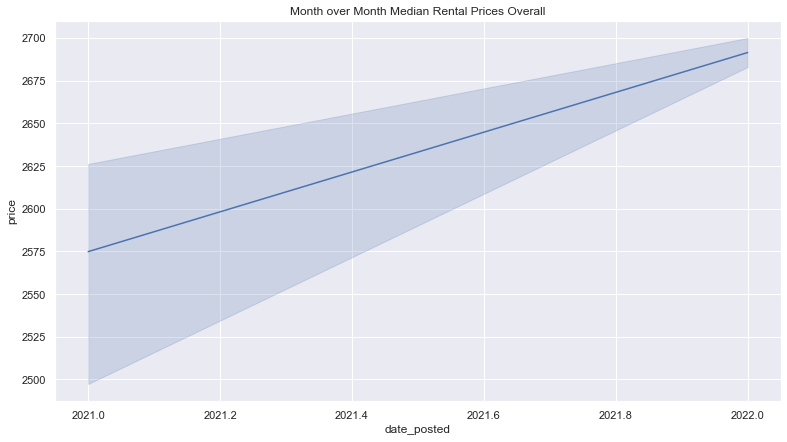

In [88]:
df_prices_monthly = df.groupby(
    [df['date_posted'].dt.month, df['date_posted'].dt.year])["price", "bedrooms", "sqft"].median()


title_prices_monthly = "Month over Month Median Rental Prices Overall"  # specify plot's title

lineplot_seaborn((13, 7), df_prices_monthly, 'date_posted', 'price', None, title_prices_monthly)



## Interpreatation: The month over month median rental prices lineplot indicates that--overall--median rental prices have consistently increased month over month between September 2021 and February 2022.

## Over this 5 month period, median rental prices have increased cummulatively by ~$125 from  $2,575 to approximately $2,700.

## The month over month increases appear to be happening at a very similar rate of growth, with no one month or set of months experiencing any particularly sharp increases in monthly prices.

## From a regression & statistical model perspective, this likely indicates autocorrelation issues since there is clearly a positive trend of rental prices (the outcome variable) over time.  

## Let's now examine whether monthly rental prices have fluctuated at different levels within the 6 subregions:

## Monthly rental prices by subregion:

d:\Coding and Code projects\Python\craigslist_data_proj\CraigslistWebScraper\craigslist_venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<AxesSubplot:title={'center':'Month over Month Median Rental Prices By Subregion'}, xlabel='date_posted', ylabel='price'>

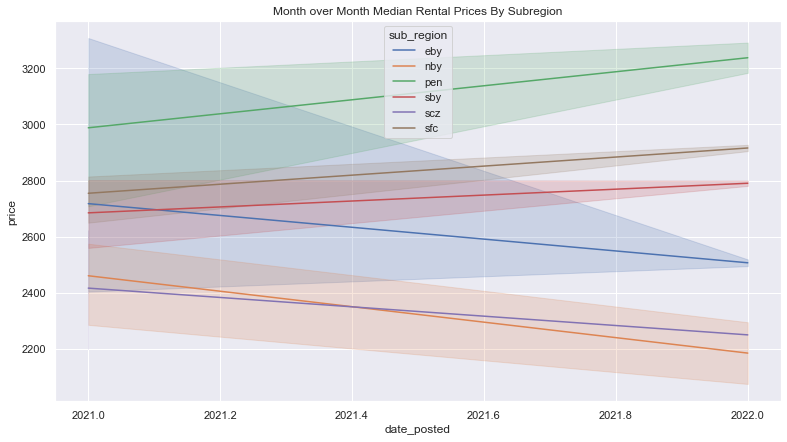

In [79]:
df_prices_monthly_subregion = df.groupby(
    [df['date_posted'].dt.month, df['date_posted'].dt.year, df['sub_region']])["price", "bedrooms", "sqft"].median()


title_prices_monthly_subregion = "Month over Month Median Rental Prices By Subregion"  # specify plot's title

lineplot_seaborn((13, 7), df_prices_monthly_subregion, 'date_posted', 'price', 'sub_region', title_prices_monthly_subregion)



## NB: Interestingly, we see that half of the 6 Bay Area subregions (including Santa Cruz) actually experienced small declines in median rental prices. 

### These subregions even include 1 heavily populated region of the SF Bay Area. Namely, subregions that saw reductions in rental prices include: Santa Cruz, the North Bay, and the East Bay.

### However, the other 3 subregions--namely, the Peninsula, South Bay, and San Francisco--experienced modereately high increases in monthly rental prices, obviously enough to counteract the slight downward trajectory of the other subregions' rental prices over this same period.


## Next, we should determine whether the time series data has significant autocorrelation issues:  

### Calculate and plot autocorrelation function for monthly 


### NB!: Check out example on calculating and plotting ACF: <https://stackoverflow.com/questions/36038927/whats-the-difference-between-pandas-acf-and-statsmodel-acf>

### Also see A Gentle Introduction to Autocorrelation and Partial Autocorrelation (2017) <https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/>



In [89]:
from statsmodels.graphics.tsaplots import plot_pacf

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 3 must be < 3.

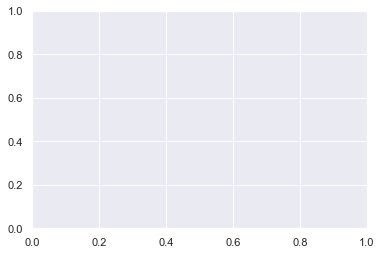

In [93]:
plot_pacf(df_prices_monthly, lags=3)

### Also see time series forecasting methods in Python/Pandas: <11 Classical Time Series Forecasting Methods in Python (Cheat Sheet) (2018)

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
>>

## Next, let's examine whether the time series is stationary:

### NB: If the time series data is not, then we should create lags as needed to achieve stationarity!

## Now, let's proceed to regression analysis:



## Since we have numerous time periods, and we have panel data with linear trend of autocorrelation (epecially since rho > 1/3), we can use a First-Differences approach to mitigate autocorrelation and also most likely mitigate omitted variable bias.  

#### One of the other underlying statistical reasons for using first-differences is we have demonstrated that there are signficant levels of autocorrelation (due to a positive trend in rental prices). 

#### To be more specific, since rho > 1/3, 1st differences can reduce the extent of autocorrelation. See following for a discussion of some of the linear algebra underlying the econometric theory at play here: <http://fmwww.bc.edu/ec-c/S2004/771/ec771.S2004.ps6.key.pdf>

#### NB2: However, First-differencing is *not guaranteed* to mitigate autocorrelation. It really only removes effects of a *linear trend* from estimating of autocorrelation.  

In [ ]:
## group data by city level



In [ ]:
## visualize and compare avg prices by city

In [ ]:
### group data by housing type--ie, apt (apartment), single_fam (ie, single family), townhouse, etc.



In [ ]:
## D.) Prepare the data for regression analysis-- bifurcate the DataFrame into the outcome variable and the covariates (ie, RHS variables), respectively

# bifurcate dataset


# 

In [ ]:
# D) - cont'd: normalize the datasetys

In [ ]:
# D) - cont'd:   use k-fold cross validation



In [ ]:
df_subreg_prices_weekday.xs()

'eby'

## E.) Perform regression analysis, interpret models, determine accuracy of models, and make predictions: